# Momentum Trading

In [1]:
import time_series_transform as tst
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time_series_transform.transform_core_api.util import *
from time_series_transform.stock_transform.util import *


In [2]:
tickList = [
    'GOOGL'
]
pe = tst.Portfolio_Extractor(tickList,'yahoo')
port = pe.get_portfolio_date('2010-06-24','2020-07-30')
port.remove_different_date()

In [3]:
def rolling_std(arr,windowSize):
    df = pd.DataFrame(arr,columns = ['tmp'])
    return df.tmp.rolling(windowSize).std().values

In [4]:
labels = []
colList = ['Open', 'High', 'Low', 'Close']
for c in colList:
    port.make_technical_indicator(c,f'{c}_wavelet',wavelet_denoising,wavelet = 'haar')
    port.make_technical_indicator(c,f'{c}_gma150',geometric_ma,windowSize = 150)
    port.make_technical_indicator(c,f'{c}_gma10',geometric_ma,windowSize = 10)
    port.make_technical_indicator(c,f'{c}_std10',rolling_std,windowSize = 10)
    port.make_technical_indicator(c,f'{c}_std50',rolling_std,windowSize = 50)
    for t in tickList:
        labels.extend([
            f'{t}_{c}',
            f'{t}_{c}_wavelet',
            f'{t}_{c}_gma50',
            f'{t}_{c}_gma10',
            f'{t}_{c}_william',
            f'{t}_{c}_std10',
            f'{t}_{c}_std50',
            f'{t}_{c}_so',
        ])
# port.make_technical_indicator('Close',f'william',williams_r)
port.make_technical_indicator('Close',f'macd',macd,return_diff=True)
port.make_technical_indicator('Close',f'so',stochastic_oscillator) 

In [5]:
df = port.get_portfolio_dataFrame()
ptspd = tst.Pandas_Time_Series_Panel_Dataset(df)
ptspd =ptspd.expand_dataFrame_by_category('Date','symbol')
ptspd = ptspd.make_slide_window('Date',30).make_lead_column('Date','Close_GOOGL',1)
df = ptspd.df
df = df.drop(['Dividends_GOOGL','Stock Splits_GOOGL'],axis =1)
df=df.sort_values('Date')

In [6]:
df['trmin'] = df[["Close_GOOGL_lead1","Close_GOOGL"]].min(axis =1)
df['trmax'] = df[["Close_GOOGL_lead1","Close_GOOGL"]].max(axis =1)
df['tr'] = (df["Close_GOOGL"] - df["trmin"])/(df['trmax'] - df['trmin'])
df["momentum"] = df["Close_GOOGL_lead1"] - df["Close_GOOGL"]
df["momentum"] = df["momentum"].apply(lambda x: 1 if x > 0 else 0)
df = df.dropna()

In [7]:
df['tr'] = df.tr.apply(lambda x: 1 if x > 0.5 else 0)
df.tr.value_counts()

0    1246
1    1115
Name: tr, dtype: int64

In [8]:
train = df[df.Date <= '2020-06-30'].sort_values('Date')
test = df[df.Date > '2020-06-30'].sort_values('Date')
trainX = train.drop(['Date','Close_GOOGL_lead1','momentum','tr','trmin','trmax'],axis = 1)
trainY = train["tr"]
testX = test.drop(['Date','Close_GOOGL_lead1','momentum','tr','trmin','trmax'],axis = 1)
testY = test["tr"]

# Machine Learning

In [9]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR,SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error,confusion_matrix
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
from scipy.stats import uniform

In [23]:
pip = Pipeline([
    ('std',StandardScaler()),
    ('pca',PCA(10,whiten = False)),
    ('svm',SVC(C = 0.5,kernel = 'poly',degree = 3))
])
hparam = {
    'pca__n_components':np.arange(2,50,dtype='int'),
    'svm__C':uniform(loc=2, scale=6),
    'svm__degree':np.arange(4,10,dtype='int'),
}
ranCV = RandomizedSearchCV(pip,hparam,
                           30,
                           scoring = 'f1',
                           cv = TimeSeriesSplit(2),
                           n_jobs = -1,
                           verbose = 50)

In [24]:
ranCV.fit(trainX,trainY)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   1

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('std',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=10,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('svm',
                                         

In [25]:
print(confusion_matrix(testY,ranCV.predict(testX)))
prd = pd.DataFrame(ranCV.predict(testX),columns = ['prd'])

[[ 0 11]
 [ 0  8]]


In [26]:
def make_momentum(predList):
    resList = []
    for i in predList:
        if i > 0.5:
            resList.append(0)
        else:
            resList.append(1)
#         meanList.append(i)
    return resList
# prd['momentum']=make_momentum(testY.tolist())
prd['momentum']=make_momentum(prd.prd.tolist())

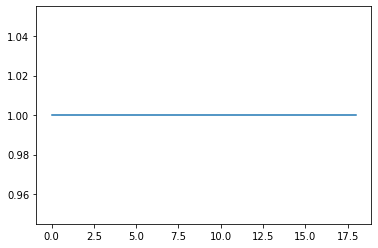

In [27]:
prd.prd.plot()

In [28]:
prd['actual_momentum'] =  df[df.Date > '2020-06-30'].momentum.values
prd['Date'] =  df[df.Date > '2020-06-30'].Date.values
prd['Close'] = testX['Close_GOOGL'].values
prd = prd.sort_values('Date')

In [29]:
def make_signale(momentumList):
    signal = []
    lastStatus = None
    for i in momentumList:
        if i == 1:
            tmp = 'buy'
        else:
            tmp = 'sell'
        if len(signal) == 0:
            if tmp == 'sell':
                signal.append('hold')
            else:
                signal.append(tmp)
        else:
            if tmp == lastStatus:
                signal.append('hold')
            else:
                signal.append(tmp)
        lastStatus = tmp
    return signal
prd['signal'] = make_signale(prd.momentum.tolist())

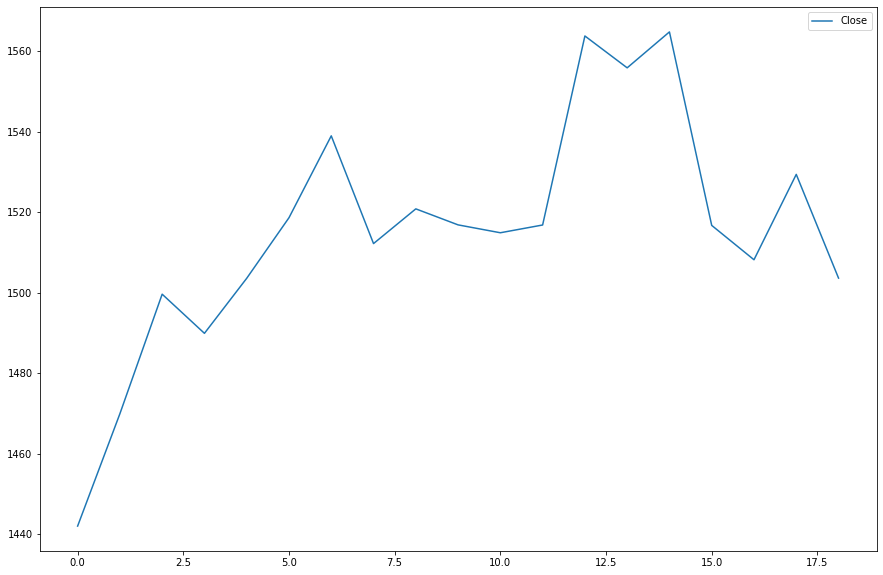

In [30]:
plt.figure(figsize=(15,10))
plt.plot(prd.Close.values)
for ix,v in enumerate(prd[['Close','signal']].values):
    if v[1] == 'buy':
        buy = plt.plot(ix,v[0],'x',label = 'buy')
    elif v[1] == 'sell':
        plt.plot(ix,v[0],'o',label='sell')
plt.legend(('Close','buy','sell'))
plt.show()

In [21]:
def profit_eval(prdDf):
    tmp = prdDf[prd.signal != 'hold'].sort_values('Date')[['signal','Close']]
    tmp = tmp.to_records()
    buy,sell = 0,0
    for ix,v in enumerate(tmp):
        if ix+1 == len(tmp) and tmp[ix][1] == 'buy':
            continue
        if tmp[ix][1] == 'buy':
            buy += tmp[ix][2]
        elif tmp[ix][1] == 'sell':
            sell += tmp[ix][2]
    return (sell-buy)/buy

In [22]:
profit_eval(prd)

0.0332316227461859

# Neural Network

In [24]:
import tensorflow as tf
from sklearn.feature_selection import SelectKBest,chi2,f_regression

In [25]:
std = StandardScaler()
tX = std.fit_transform(trainX)
dataset = tf.data.Dataset.from_tensor_slices((tX, trainY.values))
dataset = dataset.shuffle(100)

In [95]:
def get_compiled_model():
    model = tf.keras.Sequential([
#         tf.keras.layers.Dense(500, activation='relu'),
#         tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Dense(10, activation='sigmoid'),
        tf.keras.layers.Dense(1,'sigmoid')
      ])

    model.compile(optimizer=tf.keras.optimizers.Nadam(0.1,decay= 0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

In [96]:
model = get_compiled_model()
model.fit(x=tX,y=trainY.values, epochs=50,validation_split= 0.01)

Train on 2340 samples, validate on 24 samples
Epoch 1/50
2340/2340 [==============================] - 1s 465us/sample - loss: 0.7034 - accuracy: 0.5385 - val_loss: 0.7018 - val_accuracy: 0.5833
Epoch 2/50
2340/2340 [==============================] - 0s 166us/sample - loss: 0.6963 - accuracy: 0.5474 - val_loss: 0.7014 - val_accuracy: 0.5833
Epoch 3/50
2340/2340 [==============================] - 0s 164us/sample - loss: 0.6999 - accuracy: 0.5415 - val_loss: 0.8275 - val_accuracy: 0.5833
Epoch 4/50
2340/2340 [==============================] - 0s 205us/sample - loss: 0.6990 - accuracy: 0.5235 - val_loss: 0.6818 - val_accuracy: 0.5833
Epoch 5/50
2340/2340 [==============================] - 0s 169us/sample - loss: 0.6984 - accuracy: 0.5355 - val_loss: 0.7069 - val_accuracy: 0.5833
Epoch 6/50
2340/2340 [==============================] - 0s 161us/sample - loss: 0.6984 - accuracy: 0.5269 - val_loss: 0.7000 - val_accuracy: 0.4167
Epoch 7/50
2340/2340 [==============================] - 0s 207us/s

KeyboardInterrupt: 

In [92]:
ttX = std.transform(testX)
prd = pd.DataFrame(model.predict(ttX),columns = ['prd'])
prd['momentum']=make_momentum(testY.tolist(),prd.prd.tolist())

In [93]:
prd['Date'] =  df[df.Date > '2020-06-30'].Date.values
prd['Close'] = testX['Close_GOOGL'].values
prd = prd.sort_values('Date')
prd['signal'] = make_signale(prd.momentum.tolist())

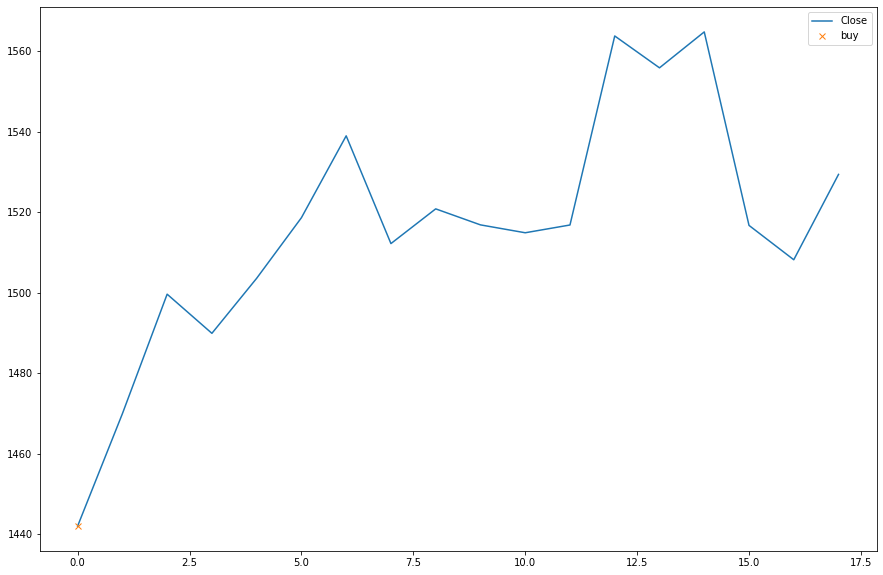

In [94]:
plt.figure(figsize=(15,10))
plt.plot(prd.Close.values)
for ix,v in enumerate(prd[['Close','signal']].values):
    if v[1] == 'buy':
        buy = plt.plot(ix,v[0],'x',label = 'buy')
    elif v[1] == 'sell':
        plt.plot(ix,v[0],'o',label='sell')
plt.legend(('Close','buy','sell'))
plt.show()

In [74]:
profit_eval(prd)

0.08519417475728149

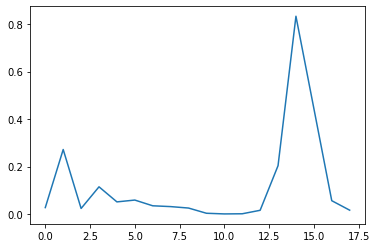

In [75]:
prd.prd.plot()